# SPAM CLASSIFICATION

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('spam.csv', encoding='latin1')

In [3]:
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
3751,ham,Why are u up so early?,NaN,NaN,NaN
4018,spam,U've been selected to stay in 1 of 250 top Bri...,NaN,NaN,NaN
2085,ham,Moji i love you more than words. Have a rich day,NaN,NaN,NaN
921,ham,On ma way to school. Can you pls send me ashle...,NaN,NaN,NaN
1977,spam,Reply to win å£100 weekly! Where will the 2006...,NaN,NaN,NaN


In [4]:
df.shape

(5572, 5)

# DATA CLEANING

In [5]:
# delete last 3 columns after using df.info
df.drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace = True)

In [6]:
df.sample(5)

,v1,v2
5149,ham,Pls call me da. What happen.
2753,ham,"Derp. Which is worse, a dude who always wants ..."
943,ham,And also I've sorta blown him off a couple tim...
1312,ham,I love u 2 babe! R u sure everything is alrite...
4090,ham,Hey doc pls I want to get nice t shirt for my ...


In [7]:
# renaming columns
df.rename(columns = {'v1': 'target', 'v2' : 'text'}, inplace = True)
df.sample(5)


,target,text
903,ham,Lovely smell on this bus and it ain't tobacco...
3264,spam,"44 7732584351, Do you want a New Nokia 3510i c..."
66,ham,"Today is \song dedicated day..\"" Which song wi..."
5051,ham,"Tick, tick, tick .... Where are you ? I could ..."
234,spam,Text & meet someone sexy today. U can find a d...


In [8]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [9]:
df['target'] = encoder.fit_transform(df['target'])

In [10]:
df.sample(5)

,target,text
4491,0,Probably a couple hours tops
4628,0,Only saturday and sunday holiday so its very d...
4264,0,&lt;DECIMAL&gt; m but its not a common car he...
2555,1,FreeMSG You have been awarded a FREE mini DIGI...
554,0,IÛ÷ll have a look at the frying pan in case i...


In [11]:
# missing values
df.isnull().sum()

target    0
text      0
dtype: int64

In [12]:
# check for duplicates
df.duplicated().sum()

403

In [13]:
# remove duplicates
df = df.drop_duplicates(keep='first')

# EXPLORATORY DATA ANALYSIS

In [14]:
df['target'].value_counts()

0    4516
1     653
Name: target, dtype: int64

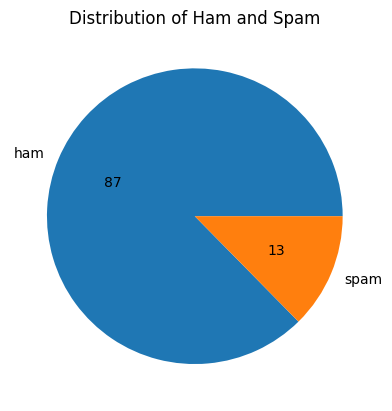

In [15]:
import matplotlib.pyplot as plt
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'],autopct = "%1.0f")
plt.title("Distribution of Ham and Spam")
plt.show()

Data is Imbalanced, much more ham data than spam

In [16]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/advikakumari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
df['num_characters'] = df['text'].apply(len)

In [18]:
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [19]:
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [20]:
df.head()

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [21]:
df[['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.453279,1.947185
std,58.236293,13.324793,1.362406
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,28.000000


In [22]:
# Ham messages summary stats:

df[df['target'] == 0][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.120903,1.799601
std,56.358207,13.493725,1.278465
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,28.000000


In [23]:
# Spam messages summary stats:

df[df['target'] == 1][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.967841
std,30.137753,7.008418,1.483201
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,8.000000


On average, spam has greater amount of characters and sentences

<Axes: >

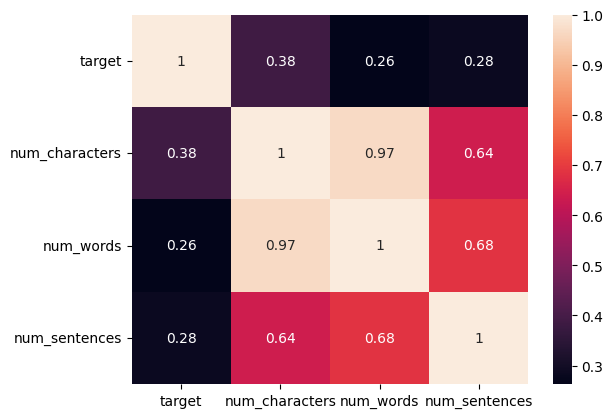

In [24]:
import seaborn as sns
sns.heatmap(df.corr(), annot=True)

We will keep the num_characters column since it provides that highest correlation between target and words

# TEXT PREPROCESSING

Make lowercase, tokenization, remove special chars, stop words and punctuation, stemming 


In [25]:
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [26]:
def transform_text(text):
    text = text.lower()             #lowercase
    text = nltk.word_tokenize(text) #tokenize
    
    y=[]
    
    for i in text:
        if i.isalnum():
            if i not in stopwords.words('english') and i not in string.punctuation:
                y.append(ps.stem(i))
            
    
    return " ".join(y)

In [27]:
transform_text("I am making a project on machine learning!")

'make project machin learn'

In [28]:
df['transformed_text'] = df['text'].apply(transform_text)
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


### Most Common Words

In [29]:
from wordcloud import WordCloud
wc = WordCloud(width=500, height=500, min_font_size=10, background_color= "white")
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

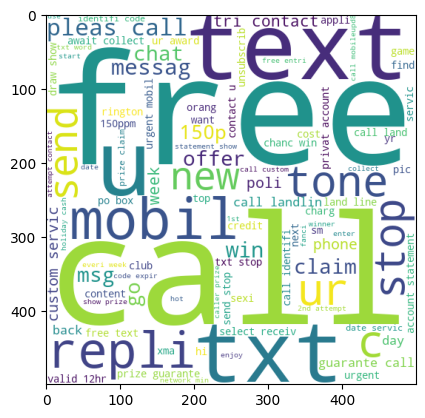

In [30]:
plt.imshow(spam_wc)

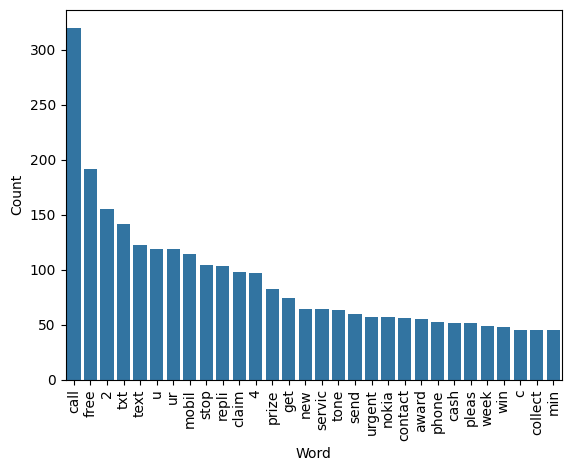

In [31]:
spam = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam.append(word)
from collections import Counter
data = pd.DataFrame(Counter(spam).most_common(30), columns=['Word', 'Count'])
sns.barplot(x='Word', y='Count', data=data)
plt.xticks(rotation='vertical')
plt.show()        

Most common words found in spam messages

# MODEL

Convert text to vectors using bag of words

In [66]:
#vectorize data use bag of words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['transformed_text']).toarray()
X.shape

(5169, 3000)

In [67]:
y = df['target'].values
y

array([0, 0, 1, ..., 0, 0, 0])

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=2)

In [69]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [70]:
bnb.fit(X_train, y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test, y_pred3))
print(confusion_matrix(y_test, y_pred3))
print(precision_score(y_test, y_pred3))

0.9835589941972921
[[895   1]
 [ 16 122]]
0.991869918699187


In [71]:
mnb.fit(X_train, y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))
print(precision_score(y_test, y_pred2))

0.9709864603481625
[[896   0]
 [ 30 108]]
1.0


In [72]:
gnb.fit(X_train, y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))
print(precision_score(y_test, y_pred1))

0.8694390715667312
[[788 108]
 [ 27 111]]
0.5068493150684932


#### BernoulliNB and MultinomialNB has the best scores. 
Precision (minimizing false positives) are more important for spam classification, so we will go ahead with MultinomialNB

#### Lets try with other models

In [73]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [74]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

In [75]:
#Dictionary to loop over different models and find best one
clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'RF': rfc, 
    'ETC': etc,
}

In [76]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [77]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

In [78]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)
performance_df

,Algorithm,Accuracy,Precision
1,KN,0.905222,1.000000
2,NB,0.970986,1.000000
3,RF,0.974855,0.982759
0,SVC,0.975822,0.974790
4,ETC,0.974855,0.974576


#### MultinomialNB has best precision + accuracy
Let's stack the best performing models and see if it can outperform NB

In [54]:
svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
mnb = MultinomialNB()
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

from sklearn.ensemble import VotingClassifier

In [55]:
voting = VotingClassifier(estimators=[('svm', svc), ('nb', mnb), ('et', etc)],voting='soft')
voting.fit(X_train,y_train)

VotingClassifier(estimators=[('svm',
                              SVC(gamma=1.0, kernel='sigmoid',
                                  probability=True)),
                             ('nb', MultinomialNB()),
                             ('et',
                              ExtraTreesClassifier(n_estimators=50,
                                                   random_state=2))],
                 voting='soft')

In [56]:
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9816247582205029
Precision 0.9917355371900827


##### The voting classifier with the top models decreases precision. Since precision is important, we will stick with MultinomialNB 

In [79]:
import pickle
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))